LDA, es una técnica de reducción supervisada.
-Su objetivo es encontrar una combinación lineal que maximice la separación entre clases y minimíce la varianza dentro de cada clase.
-Esto nos permitirá reducir variables que aún conservan la mayor discriminación posible.

In [3]:
import numpy as np #Manejo de arreglos
import matplotlib.pyplot as plt #Creacion de visualizaciones en python

X = np.array([[2,3],[3,3],[2,2],[6,5],[7,5],[6,6]])
#0 = Clase A
#1 = Clase B
y = np.array([0,0,0,1,1,1])

#Separamos por clase
clasA = X[y==0]
clasB = X[y==1]
#Medias por clase
mA=clasA.mean(axis=0).reshape(-1,1)#Regresa un nuevo array a partir del original
mB=clasB.mean(axis=0).reshape(-1,1)

print("Media de A:")
print(mA)
print()
print("Media de B:")
print(mB)

Media de A:
[[2.33333333]
 [2.66666667]]

Media de B:
[[6.33333333]
 [5.33333333]]


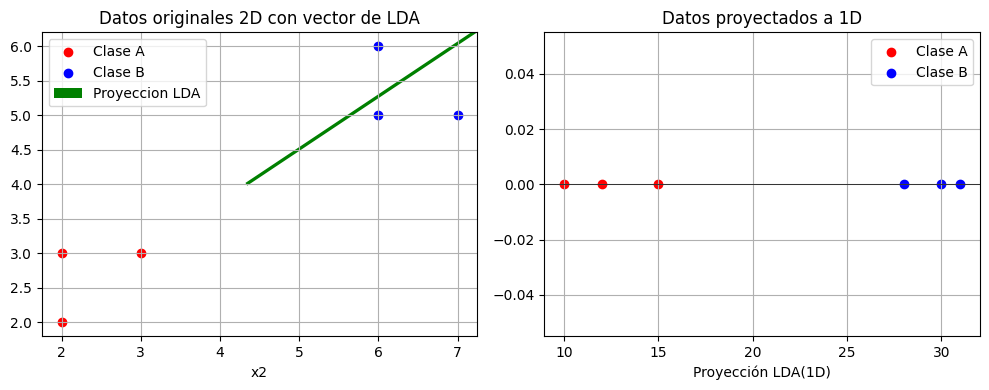

In [39]:
#Hallamos la Matriz de dispersión dentro de las clases(SW)
Sw = np.zeros((2,2)) #Creamos un array lleno de ceros
for i in clasA:
  i = i.reshape(-1,1);
  Sw = Sw + (i - mA) @ (i - mA).T

for i in clasB:
  i = i.reshape(-1,1);
  Sw = Sw + (i - mB) @ (i - mB).T

#Vector de proyección
vp = np.linalg.inv(Sw) @ (mB - mA)#linalg.inv calcula la inversa de una matriz
#Proyeccion de datos a 1D
pro_D =X @ vp

# ---------Gráfico 2D ------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(clasA[:,0],clasA[:,1],color='red',label='Clase A')#scatter para ver como se relacionan dos variables
plt.scatter(clasB[:,0],clasB[:,1],color='blue',label='Clase B')#con scatter puedo visualizar los patrones

#Eje de proyeccion
origen = np.mean(X,axis=0)#Calculamos el promedio del arreglo X
plt.quiver(*origen,vp[0],vp[1],scale=5,color='green',label='Proyeccion LDA')#quiver nos permite visualizar campos vectoriales

plt.xlabel("x1")
plt.xlabel("x2")
plt.title("Datos originales 2D con vector de LDA")
plt.legend()
plt.grid(True)#grid para la visualización de una cuadrícula

#--------- Gráfico 1d proyectado ------------
plt.subplot(1,2,2)
#Proyeccion sobre el eje horizontal
plt.scatter(pro_D[y==0],np.zeros(len(pro_D[y==0])),color='red', label='Clase A')
plt.scatter(pro_D[y==1],np.zeros(len(pro_D[y==1])),color='blue', label='Clase B')

plt.axhline(0,color='black',linewidth=0.5)#axhlinea dibuja una linea horizontal
plt.xlabel("Proyección LDA(1D)")
plt.title("Datos proyectados a 1D")
plt.legend()
plt.grid(True)

plt.tight_layout()#Evita que los elementos de subplot no se superpongan
plt.show()

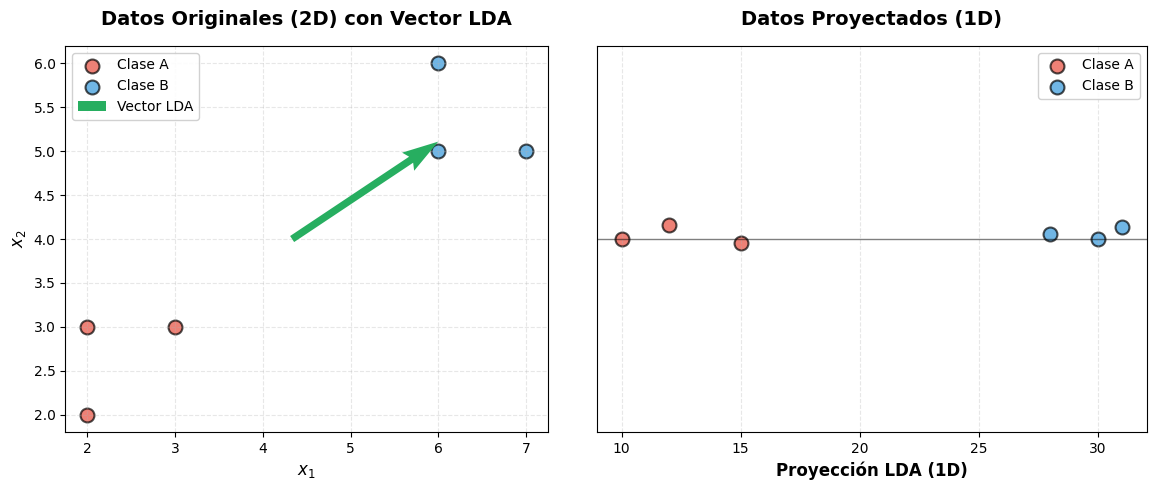

RESULTADOS DEL ANÁLISIS LDA

Clase A:
  Media: [2.333, 2.667]

Clase B:
  Media: [6.333, 5.333]

Vector de proyección:
  w = [3.0000, 2.0000]

Proyección de nuevos datos: [20. 21.]


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional


class LDA:
    """
    Implementación de Linear Discriminant Analysis (LDA) para reducción de dimensionalidad
    y clasificación de dos clases.
    """

    def __init__(self):
        self.projection_vector = None
        self.class_means = {}
        self.scatter_within = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LDA':
        """
        Entrena el modelo LDA calculando el vector de proyección óptimo.

        Args:
            X: Datos de entrada de forma (n_samples, n_features)
            y: Etiquetas de clase de forma (n_samples,)

        Returns:
            self: Instancia entrenada
        """
        classes = np.unique(y)
        if len(classes) != 2:
            raise ValueError("Esta implementación solo soporta problemas de dos clases")

        # Separar datos por clase
        X_class = {c: X[y == c] for c in classes}

        # Calcular medias por clase
        self.class_means = {c: X_class[c].mean(axis=0).reshape(-1, 1) for c in classes}

        # Calcular matriz de dispersión dentro de las clases (Sw)
        n_features = X.shape[1]
        self.scatter_within = np.zeros((n_features, n_features))

        for c in classes:
            for sample in X_class[c]:
                sample = sample.reshape(-1, 1)
                diff = sample - self.class_means[c]
                self.scatter_within += diff @ diff.T

        # Calcular vector de proyección: w = Sw^(-1) * (m1 - m0)
        mean_diff = self.class_means[classes[1]] - self.class_means[classes[0]]
        self.projection_vector = np.linalg.inv(self.scatter_within) @ mean_diff

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Proyecta los datos al espacio 1D usando el vector de proyección.

        Args:
            X: Datos de entrada de forma (n_samples, n_features)

        Returns:
            Datos proyectados de forma (n_samples, 1)
        """
        if self.projection_vector is None:
            raise ValueError("El modelo debe ser entrenado primero usando fit()")

        return X @ self.projection_vector

    def fit_transform(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Entrena el modelo y proyecta los datos en un solo paso.

        Args:
            X: Datos de entrada de forma (n_samples, n_features)
            y: Etiquetas de clase de forma (n_samples,)

        Returns:
            Datos proyectados de forma (n_samples, 1)
        """
        return self.fit(X, y).transform(X)


def visualize_lda(X: np.ndarray, y: np.ndarray, lda: LDA,
                  class_names: Optional[list] = None,
                  colors: Optional[list] = None,
                  figsize: Tuple[int, int] = (12, 5)):
    """
    Visualiza los datos originales en 2D con el vector de proyección LDA
    y los datos proyectados en 1D.

    Args:
        X: Datos de entrada (n_samples, 2)
        y: Etiquetas de clase
        lda: Modelo LDA entrenado
        class_names: Nombres personalizados para las clases
        colors: Colores personalizados para las clases
        figsize: Tamaño de la figura
    """
    if X.shape[1] != 2:
        raise ValueError("Esta visualización solo funciona con datos 2D")

    classes = np.unique(y)
    if class_names is None:
        class_names = [f'Clase {chr(65 + i)}' for i in range(len(classes))]
    if colors is None:
        colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

    # Proyectar datos
    X_projected = lda.transform(X)

    # Crear figura con subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # ============ Gráfico 1: Datos originales 2D ============
    for i, c in enumerate(classes):
        mask = y == c
        ax1.scatter(X[mask, 0], X[mask, 1],
                   color=colors[i],
                   label=class_names[i],
                   s=100,
                   alpha=0.7,
                   edgecolors='black',
                   linewidth=1.5)

    # Dibujar vector de proyección desde el centroide
    centroid = X.mean(axis=0)
    vector = lda.projection_vector.flatten()
    # Normalizar para mejor visualización
    vector_norm = vector / np.linalg.norm(vector) * 2

    ax1.quiver(centroid[0], centroid[1],
              vector_norm[0], vector_norm[1],
              scale=1, scale_units='xy',
              color='#27AE60',
              width=0.015,
              label='Vector LDA',
              zorder=5)

    ax1.set_xlabel('$x_1$', fontsize=12, fontweight='bold')
    ax1.set_ylabel('$x_2$', fontsize=12, fontweight='bold')
    ax1.set_title('Datos Originales (2D) con Vector LDA',
                 fontsize=14, fontweight='bold', pad=15)
    ax1.legend(loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_aspect('equal', adjustable='box')

    # ============ Gráfico 2: Datos proyectados 1D ============
    for i, c in enumerate(classes):
        mask = y == c
        # Añadir pequeña variación vertical para mejor visualización
        y_jitter = np.random.normal(0, 0.02, sum(mask))
        ax2.scatter(X_projected[mask], y_jitter,
                   color=colors[i],
                   label=class_names[i],
                   s=100,
                   alpha=0.7,
                   edgecolors='black',
                   linewidth=1.5)

    ax2.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
    ax2.set_xlabel('Proyección LDA (1D)', fontsize=12, fontweight='bold')
    ax2.set_yticks([])
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_title('Datos Proyectados (1D)',
                 fontsize=14, fontweight='bold', pad=15)
    ax2.legend(loc='best', framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--', axis='x')

    plt.tight_layout()
    plt.show()

    # Imprimir información estadística
    print("=" * 60)
    print("RESULTADOS DEL ANÁLISIS LDA")
    print("=" * 60)
    for i, c in enumerate(classes):
        mean = lda.class_means[c].flatten()
        print(f"\n{class_names[i]}:")
        print(f"  Media: [{mean[0]:.3f}, {mean[1]:.3f}]")

    print(f"\nVector de proyección:")
    print(f"  w = [{lda.projection_vector[0, 0]:.4f}, {lda.projection_vector[1, 0]:.4f}]")
    print("=" * 60)


# ==================== EJEMPLO DE USO ====================
if __name__ == "__main__":
    # Datos de ejemplo
    X = np.array([[2, 3], [3, 3], [2, 2], [6, 5], [7, 5], [6, 6]])
    y = np.array([0, 0, 0, 1, 1, 1])

    # Crear y entrenar modelo LDA
    lda = LDA()
    lda.fit(X, y)

    # Visualizar resultados
    visualize_lda(X, y, lda,
                 class_names=['Clase A', 'Clase B'],
                 colors=['#E74C3C', '#3498DB'])

    # Proyectar nuevos datos
    X_new = np.array([[4, 4], [5, 3]])
    X_new_projected = lda.transform(X_new)
    print(f"\nProyección de nuevos datos: {X_new_projected.flatten()}")